<a href="https://colab.research.google.com/github/leiverandres/MISC-machine-learning/blob/master/faceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #3: Face recognition task

Leiver Andres Campeón  -  Juan Sebatián Vega

The goal of this assigment is to compare two machine learning algorithms and understand the importants that dimensionality reduction

In [1]:
!pip3 install tensorflow==2.0.0-beta1;
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
import tensorflow as tf


     |████████████████████████████████| 87.9MB 1.2MB/s 
     |████████████████████████████████| 3.1MB 34.8MB/s 
     |████████████████████████████████| 501kB 47.3MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


## Overall dataset acquisition

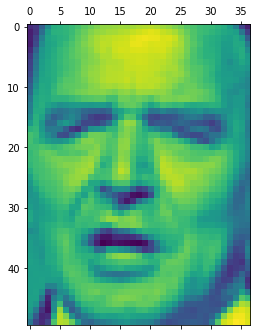

In [4]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4, )
data = lfw_people.data
target = lfw_people.target

plt.matshow(lfw_people.images[1])
plt.show()

In [8]:
k_classes = len(lfw_people.target_names)
examples, height, width = lfw_people.images.shape 
features = height * width

X = lfw_people.images
y = lfw_people.target

print(f"This dataset contains {examples} examples")
print(f"For {k_classes} classes, each image is {height}x{width}")
print(f"Features: {features}")

This dataset contains 1140 examples
For 5 classes, each image is 50x37
Features: 1850


In [9]:
class2idx = {name: idx for (idx, name) in enumerate(lfw_people.target_names)}
idx2class = {idx: class_name for class_name, idx in class2idx.items()}
print(class2idx)
print(idx2class)

{'Colin Powell': 0, 'Donald Rumsfeld': 1, 'George W Bush': 2, 'Gerhard Schroeder': 3, 'Tony Blair': 4}
{0: 'Colin Powell', 1: 'Donald Rumsfeld', 2: 'George W Bush', 3: 'Gerhard Schroeder', 4: 'Tony Blair'}


### Get train, val, and test splits


In [11]:
# Get train, val, test splits

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5)
print(f'Train split(70%): {len(y_train)}')
print(f'Validation split(15%): {len(y_val)}')
print(f'Test split(15%): {len(y_test)}')

Train split(70%): 798
Validation split(15%): 171
Test split(15%): 171


## Using vanilla SVM

In [12]:
# Unroll images into vectors
X_train_r = X_train.reshape((X_train.shape[0], -1))
X_val_r = X_val.reshape((X_val.shape[0], -1))
print(X_train_r.shape)
print(X_val_r.shape)

(798, 1850)
(171, 1850)


In [13]:
svc_clf = SVC()
svc_clf.fit(X_train_r, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [14]:
train_score = svc_clf.score(X_train_r, y_train)
val_score = svc_clf.score(X_val_r, y_val)

print(f"Train score: {train_score * 100}")
print(f"Val score: {val_score * 100}")

Train score: 100.0
Val score: 47.953216374269005


Obviously the model is overfitting

### Grid search

Let's try to get the best possible parameters to fit our dataset with SVM algorithm


In [15]:
params = {
    'kernel': ('poly', 'rbf'),
    'C': (1, 0.25, 0.5, 0.75),
    'gamma': (1, 2, 3, 'auto'),
    'decision_function_shape': ('ovo', 'ovr'),
    'shrinking': (True, False)
}

clf = GridSearchCV(estimator=svc_clf, param_grid=params, n_jobs=-1)
clf.fit(X_train_r, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': (1, 0.25, 0.5, 0.75),
                         'decision_function_shape': ('ovo', 'ovr'),
                         'gamma': (1, 2, 3, 'auto'), 'kernel': ('poly', 'rbf'),
                         'shrinking': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [16]:
import pandas as pd

df = pd.DataFrame(clf.cv_results_)

print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 1, 'kernel': 'poly', 'shrinking': True}
0.8458646616541353


In [17]:
grid_val_score = clf.score(X_val_r, y_val)
print(grid_val_score)

0.8245614035087719


We have resolved overfitting since now train and error scores are closer, however we still suffer a little of high bias, let's try some strategy to reduce it

## Using PCA before SVM

Extracting the top 100 eigenfaces from 798 faces


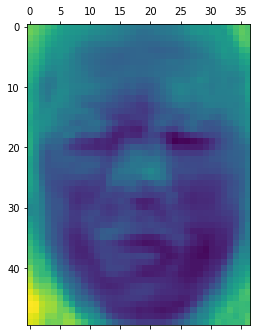

Projecting the input data on the eigenfaces orthonormal basis


In [18]:
n_components = 100

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train_r.shape[0]))

pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True)
pca = pca.fit(X_train_r)

eigenfaces = pca.components_.reshape((n_components, height, width))
plt.matshow(eigenfaces[0])
plt.show()
print("Projecting the input data on the eigenfaces orthonormal basis")

X_train_pca = pca.transform(X_train_r)
X_val_pca = pca.transform(X_val_r)


In [19]:
svc_pca_clf = SVC()
svc_pca_clf.fit(X_train_pca, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [20]:
train_score_pca = svc_pca_clf.score(X_train_pca, y_train)
val_score_pca = svc_pca_clf.score(X_val_pca, y_val)
print(f"Train score: {train_score_pca}")
print(f"Val score: {val_score_pca}")

Train score: 0.9912280701754386
Val score: 0.8362573099415205


In [21]:
params = {
    'kernel': ('poly', 'rbf'),
    'C': (1, 0.25, 0.5, 0.75),
    'gamma': (1, 2, 3, 'auto'),
    'decision_function_shape': ('ovo', 'ovr'),
    'shrinking': (True, False)
}

clf = GridSearchCV(estimator=svc_pca_clf, param_grid=params, n_jobs=-1)
clf.fit(X_train_pca, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': (1, 0.25, 0.5, 0.75),
                         'decision_function_shape': ('ovo', 'ovr'),
                         'gamma': (1, 2, 3, 'auto'), 'kernel': ('poly', 'rbf'),
                         'shrinking': (True, False)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [22]:
import pandas as pd

df = pd.DataFrame(clf.cv_results_)
print(clf.best_params_)
print(clf.best_score_)

{'C': 1, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}
0.7744360902255639


In [23]:
grid_val_score = clf.score(X_val_pca, y_val)
print(grid_val_score)

0.8362573099415205


Only by using PCA we got great results without too much tuning.

## Using neural networks

In [0]:
import tensorflow as tf
layers = tf.keras.layers

In [0]:
def build_model(input_units, num_labels):
  model = tf.keras.models.Sequential([
        layers.Dense(300, activation='relu', input_shape=(input_units, )),
        layers.Dropout(rate=0.4),  
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dropout(rate=0.4),
        layers.Dense(300, activation='relu'),
        layers.Dropout(rate=0.4),
        layers.Dense(num_labels, activation='softmax'),
    ])
  return model

In [26]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Encode labels
classes = list(range(k_classes))
y_train_tr = label_binarize(y_train, classes=classes)
y_val_tr = label_binarize(y_val, classes=classes)
"""
Normalize features
This is an usual trick for image data normalization
the goal is to avoid computing mean and std from each channel
"""
X_train_scaled = X_train_r / 255.0
X_val_scaled = X_val_r / 255.0

print(np.mean(X_train_scaled), np.std(X_train_scaled))
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(y_train_tr.shape)
print(y_val_tr.shape)

print('Encoding example')
print(y_train[3])
print(y_train_tr[3])

0.52047396 0.1737373
(798, 1850)
(171, 1850)
(798, 5)
(171, 5)
Encoding example
0
[1 0 0 0 0]


In [0]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train_scaled, y_train_tr)).shuffle(800).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_tr)).batch(32)

In [53]:
model = build_model(input_units=features, num_labels=k_classes)
#print(model.summary())
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
EPOCHS = 500

@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
      logits = model(images)
      loss_value = loss_object(labels, logits)
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  
  train_loss(loss_value)
  train_accuracy(labels, logits)

@tf.function
def test_step(images, labels):
  logits = model(images)
  t_loss = loss_object(labels, logits)

  test_loss(t_loss)
  test_accuracy(labels, logits)

for epoch in range(EPOCHS):
  for images, labels in train_ds:
    train_step(images, labels)
  for images, labels in val_ds:
    test_step(images, labels)
  
  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))

Epoch 1, Loss: 1.4984318017959595, Accuracy: 42.60651779174805, Test Loss: 1.452796459197998, Test Accuracy: 47.953216552734375
Epoch 2, Loss: 1.4645171165466309, Accuracy: 44.98746871948242, Test Loss: 1.4417880773544312, Test Accuracy: 49.41520309448242
Epoch 3, Loss: 1.4176069498062134, Accuracy: 47.36842346191406, Test Loss: 1.3989704847335815, Test Accuracy: 51.07212829589844
Epoch 4, Loss: 1.390507698059082, Accuracy: 48.46491241455078, Test Loss: 1.3632878065109253, Test Accuracy: 52.6315803527832
Epoch 5, Loss: 1.3430708646774292, Accuracy: 50.30075454711914, Test Loss: 1.3270009756088257, Test Accuracy: 53.918128967285156
Epoch 6, Loss: 1.3058563470840454, Accuracy: 51.79615783691406, Test Loss: 1.2917537689208984, Test Accuracy: 55.0682258605957
Epoch 7, Loss: 1.2669700384140015, Accuracy: 53.168636322021484, Test Loss: 1.2614665031433105, Test Accuracy: 56.05680847167969
Epoch 8, Loss: 1.231195330619812, Accuracy: 54.46428680419922, Test Loss: 1.2375296354293823, Test Accura

After this training we can tell that the model is overfitting, so possibles solutions to that would be:

* Use more data for training, which might mean augment existing dataset thru transformations.
* Add batch normalization.
* Add regularization or tune dropout layers, even add more.
* Maybe try with convolutional architecture.